Запуск обучения моделей с параметрами как в конфиге TabDDPM на данных, где на категориальных признаках используется OHE. Этот датасет подается TabDDPM как полностью числовой (число категориальных переменных равно 0). Внутри обучения модели на каждом шаге цикла обучения при получении батча происходит добавление шума $N(0, \sigma)$, где $\sigma$ как раз меняется от модели к модели. У первых нескольких моделей она константная, у остальных моделей есть некое ее изменение (постепенное уменьшение). 

Нормализация данных: quantile для числовых метрик и Standart Scaler для OHE

Добавление шума: ко всем

Число эпох обучения: 100'000

Dataset: shoppers

In [1]:
%cd ..

/workspace/TabDDPM_copy/TabDDPM


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm_ON_QnSC.tabddpm_ON_QnSC import *

from tqdm.notebook import tqdm

### Cкачиваем и преобразовываем данные

In [3]:
dataname = 'shoppers_ON_QnSC_100k'
model_name = 'tabddpm_ON_QnSC'
model_name_postfix = '_100k'

In [4]:
dataname_initial = 'shoppers'
# download_dataset(dataname_initial)
# process_data(dataname_initial)

In [6]:
import shutil
try:
    shutil.rmtree(f'./data/{dataname}')
except Exception as e:
    print(e)


with open(f'data/Info/{dataname_initial}.json', 'r') as f:
    info = json.load(f)

info['name'] = dataname
info['data_path'] = f'data/{dataname}/online_shoppers_intention.csv'
info['task_type'] = 'regression'

with open(f'data/Info/{dataname}.json', 'w', encoding='utf-8') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)

download_dataset(dataname_initial, dataname)

normalizers = categorial_to_OHE(dataname, do_quantile_and_standart_scale=True)
process_data(dataname)
postprocess_OHE(dataname, dataname_initial)

Start processing dataset shoppers from UCI.
Finish downloading dataset from https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip, data has been saved to data/shoppers_ON_QnSC_100k.
Finish unzipping shoppers.
{'cat_col_idx': [],
 'cat_col_idx_initial': [10, 11, 12, 13, 14, 15, 16],
 'column_info': {'0': 'float',
                 '1': 'float',
                 '10_Aug_after_OHE': 'float',
                 '10_Dec_after_OHE': 'float',
                 '10_Feb_after_OHE': 'float',
                 '10_Jul_after_OHE': 'float',
                 '10_June_after_OHE': 'float',
                 '10_Mar_after_OHE': 'float',
                 '10_May_after_OHE': 'float',
                 '10_Nov_after_OHE': 'float',
                 '10_Oct_after_OHE': 'float',
                 '10_Sep_after_OHE': 'float',
                 '11_1_after_OHE': 'float',
                 '11_2_after_OHE': 'float',
                 '11_3_after_OHE': 'float',
                 '11_

In [7]:
from pickle import dump, load

if globals().get('normalizers'):
    dump(normalizers['num_normalizer'], open(f'./data/{dataname}/num_normalizer_{dataname}.pkl', 'wb'))
    dump(normalizers['cat_normalizer'], open(f'./data/{dataname}/cat_normalizer_{dataname}.pkl', 'wb'))
    
    with open(f'data/{dataname}/normalizers.json', 'w', encoding='utf-8') as f:
        json.dump({
                        'len_num_prev':normalizers['len_num_prev'],
                        'len_cat_prev':normalizers['len_cat_prev'],
                        'len_target_prev':normalizers['len_target_prev'],
                    }, f, ensure_ascii=False, indent=4)
    print(f"normalizers saved to `data/{dataname}` folder")
else:
    with open(f'data/{dataname}/normalizers.json', 'r') as f:
        normalizers = json.load(f)
    normalizers['num_normalizer'] = load(open(f'./data/{dataname}/num_normalizer_{dataname}.pkl', 'rb'))
    normalizers['cat_normalizer'] = load(open(f'./data/{dataname}/cat_normalizer_{dataname}.pkl', 'rb'))
    print(f"normalizers received from `data/{dataname}` folder")

normalizers saved to `data/shoppers_ON_QnSC_100k` folder


### Подготовка

In [8]:
with open(f'data/Info/{dataname}.json', 'r') as f:
    info = json.load(f)

In [9]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)

In [10]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('save_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")
CONFIG.add_arg('sample_save_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")

Device: cuda


### Train

In [11]:
CONFIG.add_arg('mode', 'train')
CONFIG.add_arg('num_noise', info['prev_cat_num'])

CONFIG.add_arg('info_path', None)
                   # f"data/{CONFIG.get_arg('dataname')}/info.json")
CONFIG.add_arg('real_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/real.csv")
CONFIG.add_arg('test_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/test.csv")

In [12]:
CONFIG.add_arg('dataname', None)
CONFIG.add_arg('method', None)
CONFIG.add_arg('device', None)

In [13]:
CONFIG.get_all_args()

{'dataname': None,
 'method': None,
 'device': None,
 'mode': 'train',
 'train': 1,
 'sample_save_path': None,
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 66,
 'real_path': None,
 'test_path': None,
 'info_path': None,
 'save_path': None}

In [14]:
sigma = 0
f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"

'./models/tabddpm_ON_QnSC/ckpt/shoppers/tabddpm_ON_QnSC_100k_const_0'

In [ ]:
model_save_path_hist = []
for sigma in [0.01, 0.25, 0]:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"
    model_save_path_hist.append(model_save_path)

    tabddpm_noise_ohe = TabDDPM_OHE_Noise_QnSC(CONFIG, model_save_path=model_save_path, sigmas=np.ones(100000) * sigma,
                                         dataname=dataname, device=device)
    tabddpm_noise_ohe.train()

    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    start_step = 0
    for l in loss.columns[1:]:
      plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])  
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    
    plt.show()
    
    for file in tqdm(os.listdir(model_save_path)):
        if ('0000' in file) or ('model_ema.pt' in file):
            os.remove(os.path.join(model_save_path, file))

START TRAINING
No NaNs in numerical features, skipping
76
{'num_classes': 2, 'is_y_cond': False, 'rtdl_params': {'d_layers': [1024, 2048, 2048, 1024], 'dropout': 0.0}, 'd_in': 76}
mlp
MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=1024, out_features=2048, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=2048, out_features=2048, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=2048, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (head): Linear(in_features=1024, out_feature

In [6]:
sigmas_list = []

# linear from 0.25 to 0.01
sigmas_list.append(np.linspace(0.25, 0.01, 100000))

# cosine from 0.5 to 0
sigmas_list.append((np.cos(np.linspace(0, np.pi, 100000)) + 1) * 0.5 / 2)

idx = [5, 6]

In [ ]:
for i, sigmas in zip(idx, sigmas_list):
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_mult_{i}"
    model_save_path_hist.append(model_save_path)
    
    tabddpm_noise_ohe = TabDDPM_OHE_Noise_QnSC(CONFIG, model_save_path=model_save_path, sigmas=sigmas,
                                         dataname=dataname, device=device)
    tabddpm_noise_ohe.train()

    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    start_step = 0
    for l in loss.columns[1:]:
      plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    
    plt.show()

    for file in tqdm(os.listdir(model_save_path)):
        if ('0000' in file) or ('model_ema.pt' in file):
            os.remove(os.path.join(model_save_path, file))

In [7]:
model_save_path_hist = []
for sigma in [0.01, 0.25, 0]:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"
    model_save_path_hist.append(model_save_path)

for i in idx:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_mult_{i}"
    model_save_path_hist.append(model_save_path)

In [8]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    
cmap = get_cmap(len(model_save_path_hist))

/tmp/ipykernel_23573/248767542.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


In [9]:
model_save_path_hist

['./models/tabddpm_ON_QnSC/ckpt/shoppers/tabddpm_ON_QnSC_100k_const_0_01',
 './models/tabddpm_ON_QnSC/ckpt/shoppers/tabddpm_ON_QnSC_100k_const_0_25',
 './models/tabddpm_ON_QnSC/ckpt/shoppers/tabddpm_ON_QnSC_100k_const_0',
 './models/tabddpm_ON_QnSC/ckpt/shoppers/tabddpm_ON_QnSC_100k_mult_5',
 './models/tabddpm_ON_QnSC/ckpt/shoppers/tabddpm_ON_QnSC_100k_mult_6']

0it [00:00, ?it/s]

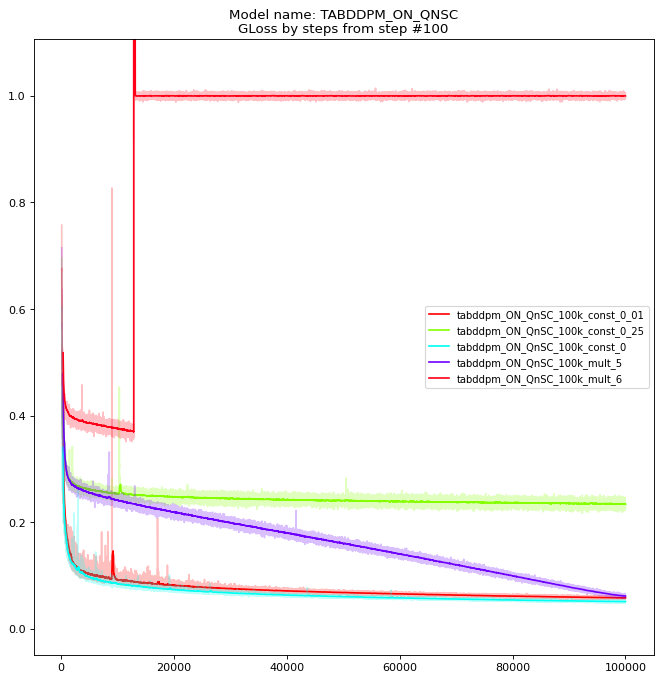

In [10]:
plt.figure(figsize=(10, 10), dpi=80)

max_v, min_v = -np.inf, np.inf
window = 250

for i, model_save_path in tqdm(enumerate(model_save_path_hist)):
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], alpha=0.25, color=cmap(i))

    smoothed = np.convolve(loss['gloss'][start_step:], np.ones(window)/window, 'valid')  
    plt.plot(loss['step'][start_step+window-1:], smoothed, label=model_save_path.split('/')[-1], color=cmap(i))

    max_v = np.max([np.quantile(loss['gloss'][start_step:], 0.99), max_v])
    min_v = np.min([np.quantile(loss['gloss'][start_step:], 0.01), min_v])

plt.ylim([min_v-0.1, max_v+0.1])    
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nGLoss by steps from step #{start_step}")

plt.savefig(f'total_loss/{dataname_initial}/total_loss_image_{model_name}{model_name_postfix}.png')

plt.show()

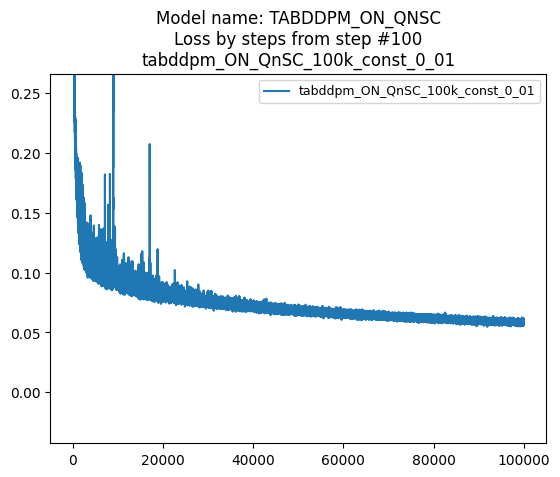

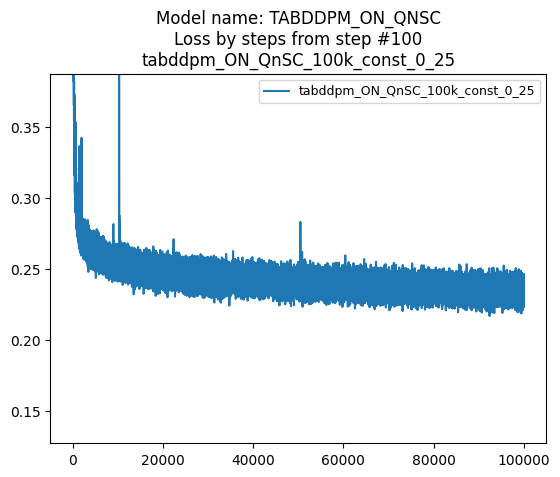

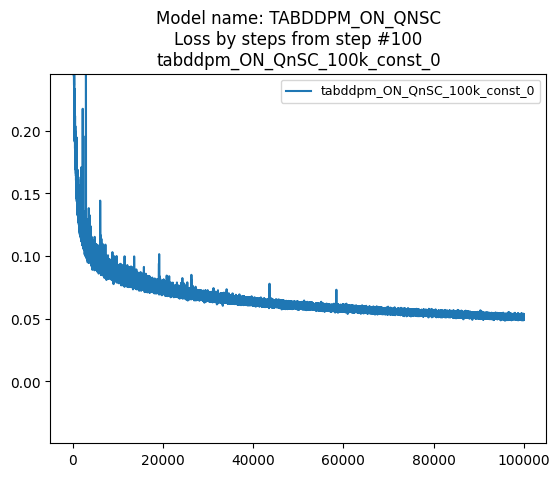

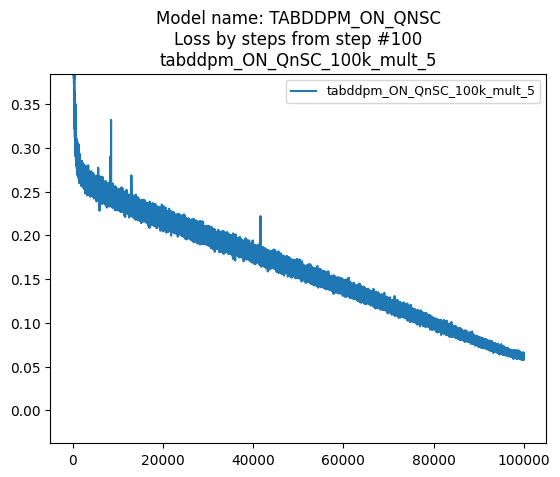

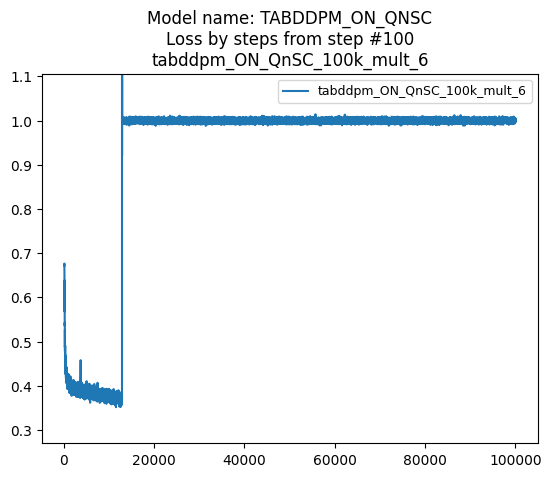

In [32]:
for model_save_path in model_save_path_hist:
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], label=model_save_path.split('/')[-1])

    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])    
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    plt.show()